## To - Do
- Double check solutions now are kinda as expected
- Boundary condition of outflow should be fixed (WIP)
- Naca profile should be implemented (Right now half a circle is possible)

# Navier-Stokes simulation in 2D
Currently only the simulation of a pressure driven lid is possible. This can be extended by adding more possibilities to the function 'set_BC'.

Init time 2.2 s
Iteration number: 1
Iteration number: 50
Iteration number: 100
Iteration number: 100


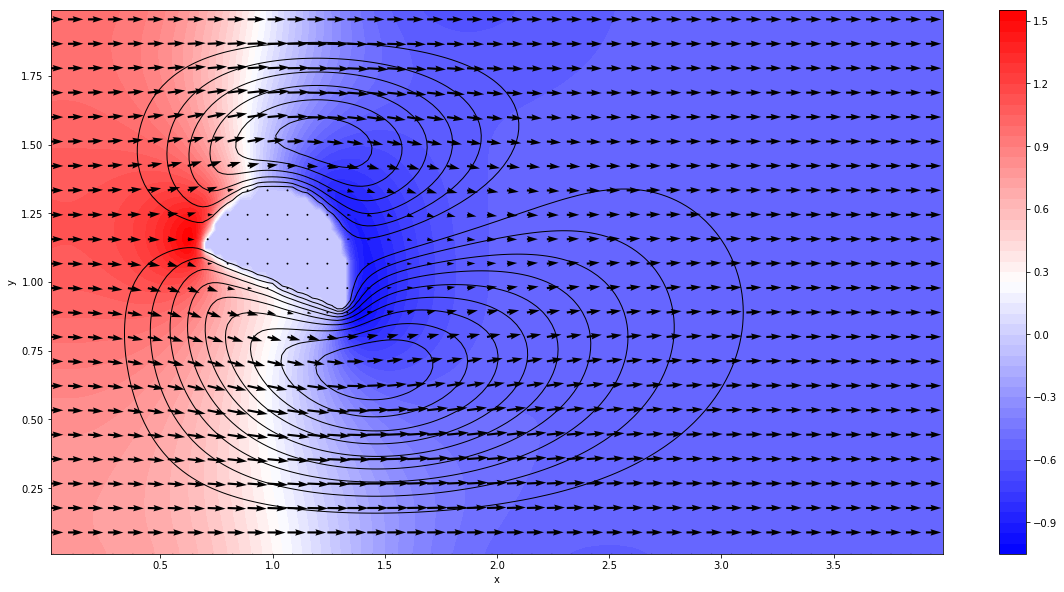

Maximum number of iterations (100) has been reached.
Runtime 10.01 s


In [3]:
#%matplotlib notebook
import time
import numpy as np
import scipy as sci
import math

from types import SimpleNamespace

from functions import *
from constants import *
from simulation import *

start_time = time.time()

# Initial conditions 
const = SimpleNamespace()

multiplier = 3

const.Re = 1e1            # Reynolds number
const.dt = 1e-2           # time step
const.tf = 1e0            # final time
const.nx = 60*multiplier  # number of x-gridpoints
const.ny = 30*multiplier  # number of y-gridpoints
const.lx = 4              # width of box
const.ly = 2              # height of box
const.cholesky = True
const.velocity = 1

# Data Processing settings
const.nsteps = 10      # step interval for graphic output
const.rho_arrow = 10   # Density of arrows in quiver plot per unit length l
const.plot_P = True
const.plot_U = True
const.plot_Q = True

const.save_fig = True
const.fig_dir ='./movie_images/' 
const.fig_id = str(np.round(const.nx)) + '_' + str(np.round(const.ny)) + '_' + 'th' 
    
## Set other constants (incl. grid) which are determined by initial conditions specified above
const = constants(const)

# IC's
data = SimpleNamespace()
data = initialisation(const, data)

# BC's
## North, East, South, West
bc = SimpleNamespace()
boundary_type = 'horizontal_sea'
bc = set_BC(const, bc, boundary_type)

## Object 
obj = SimpleNamespace(sort = 'hemicircle')
obj = creat_obj(const, obj)

# Boundary matrices
bc = set_BM(const, bc) # Maybe change const. to bc.

# Operator matrices on P, U, V, Q respectively
LP = SimpleNamespace()
LP = laplacian(const, LP)
LP = laplace_obj(const, LP, obj)
if const.cholesky:
    LP = cholesky_decomposition(LP)
    
init_time = time.time()
print('Init time', np.round(init_time - start_time,2), 's')

# Simulation
simulation_data = simulation(const, bc, obj, LP, data, boundary_type)

end_time = time.time()
print('Runtime', np.round(end_time - start_time,2), 's')

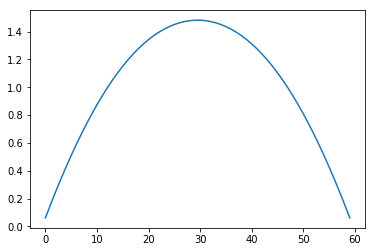

In [8]:
plt.plot(data.U[50,:])
plt.show()

# Energy check

In [ ]:
#%matplotlib notebook
plt.plot(data.kin_energy)
plt.show()

# Preliminary object function

In [1]:
def laplace_obj(const, LP, obj):
    """WIP 
    Function expects object grids, and LP. Based on the grids LP gets modified
    such that nothing flows into the object or out of it. 
    """
    if obj.sort != None:
        lp_row = const.nx
        lq_row = const.nx-1
        lu_row = const.nx-1
        lv_row = const.nx 

        x_factor = (const.dt / const.Re)/const.hx**2
        y_factor = (const.dt / const.Re)/const.hy**2   

        # Object in Lp 
        for obj_col, obj_row in np.transpose(obj.coord_P):
            m_start = obj_row*lp_row

            obj_n = m_start+obj_col
            obj_m = m_start+obj_col
            
            ## Takes care of 0 seting in Laplace            
            LP.Lp[obj_n+1, obj_m] = 0
            LP.Lp[obj_n-1, obj_m] = 0            
            
            LP.Lp[obj_n, obj_m-1] = 0
            LP.Lp[obj_n, obj_m+1] = 0
            
            LP.Lp[obj_n, obj_m-lp_row] = 0
            LP.Lp[obj_n, obj_m+lp_row] = 0
            
            LP.Lp[obj_n-lp_row, obj_m] = 0
            LP.Lp[obj_n+lp_row, obj_m] = 0
            
            ## Make matrix again postitive definite 
            ## Horizontal neighbours  
            LP.Lp[obj_n-1, obj_m-1] = LP.Lp[obj_n-1, obj_m-1] - 1
            LP.Lp[obj_n+1, obj_m+1] = LP.Lp[obj_n+1, obj_m+1] - 1
            ## Vertical neighbours 
            LP.Lp[obj_n-lp_row, obj_m-lp_row] = LP.Lp[obj_n-lp_row, obj_m-lp_row] - 1
            LP.Lp[obj_n+lp_row, obj_m+lp_row] = LP.Lp[obj_n+lp_row, obj_m+lp_row] - 1 
            
        # Object in Lq
        for obj_col, obj_row in np.transpose(obj.coord_P):
            m_start = obj_row*lq_row

            obj_n = m_start+obj_col
            obj_m = m_start+obj_col
            
            ## Takes care of 0 seting in Laplace            
            LP.Lq[obj_n+1, obj_m] = 0
            LP.Lq[obj_n-1, obj_m] = 0            
            
            LP.Lq[obj_n, obj_m-1] = 0
            LP.Lq[obj_n, obj_m+1] = 0
            
            LP.Lq[obj_n, obj_m-lq_row] = 0
            LP.Lq[obj_n, obj_m+lq_row] = 0
            
            LP.Lq[obj_n-lq_row, obj_m] = 0
            LP.Lq[obj_n+lq_row, obj_m] = 0
            
            ## Make matrix again postitive definite 
            ## Horizontal neighbours  
            LP.Lq[obj_n-1, obj_m-1] = LP.Lq[obj_n-1, obj_m-1] - 1
            LP.Lq[obj_n+1, obj_m+1] = LP.Lq[obj_n+1, obj_m+1] - 1
            ## Vertical neighbours 
            LP.Lq[obj_n-lq_row, obj_m-lq_row] = LP.Lp[obj_n-lq_row, obj_m-lq_row] - 1
            LP.Lq[obj_n+lq_row, obj_m+lq_row] = LP.Lp[obj_n+lq_row, obj_m+lq_row] - 1    

        # Object in Lu
        for obj_col, obj_row in np.transpose(obj.coord_U):
            m_start = obj_row*lu_row

            obj_n = m_start+obj_col
            obj_m = m_start+obj_col
            
            ## Takes care of 0 seting in Laplace            
            LP.Lu[obj_n+1, obj_m] = 0
            LP.Lu[obj_n-1, obj_m] = 0            
            
            LP.Lu[obj_n, obj_m-1] = 0
            LP.Lu[obj_n, obj_m+1] = 0
            
            LP.Lu[obj_n, obj_m-lu_row] = 0
            LP.Lu[obj_n, obj_m+lu_row] = 0
            
            LP.Lu[obj_n-lu_row, obj_m] = 0
            LP.Lu[obj_n+lu_row, obj_m] = 0
            
            ## Make matrix again postitive definite 
            ## Horizontal neighbours 
            #LP.Lu[obj_n-1, obj_m-1] = LP.Lu[obj_n-1, obj_m-1] - x_factor
            #LP.Lu[obj_n+1, obj_m+1] = LP.Lu[obj_n+1, obj_m+1] - x_factor
            
            ## Vertical neighbours 
            #LP.Lu[obj_n-lu_row, obj_m-lu_row] = LP.Lu[obj_n-lu_row, obj_m-lu_row] - y_factor
            #LP.Lu[obj_n+lu_row, obj_m+lu_row] = LP.Lu[obj_n+lu_row, obj_m+lu_row] - y_factor  

        # Object in Lv
        for obj_col, obj_row in np.transpose(obj.coord_V):
            m_start = obj_row*lv_row

            obj_n = m_start+obj_col
            obj_m = m_start+obj_col
            
            ## Takes care of 0 seting in Laplace            
            LP.Lv[obj_n+1, obj_m] = 0
            LP.Lv[obj_n-1, obj_m] = 0            
            
            LP.Lv[obj_n, obj_m-1] = 0
            LP.Lv[obj_n, obj_m+1] = 0
            
            LP.Lv[obj_n, obj_m-lv_row] = 0
            LP.Lv[obj_n, obj_m+lv_row] = 0
            
            LP.Lv[obj_n-lv_row, obj_m] = 0
            LP.Lv[obj_n+lv_row, obj_m] = 0    
            
            ## Make matrix again postitive definite 
            ## Horizontal neighbours
            #LP.Lv[obj_n-1, obj_m-1] = LP.Lv[obj_n-1, obj_m-1] - x_factor
            #LP.Lv[obj_n+1, obj_m+1] = LP.Lv[obj_n+1, obj_m+1] - x_factor
            ## Vertical neighbours 
            #LP.Lv[obj_n-lv_row, obj_m-lv_row] = LP.Lv[obj_n-lv_row, obj_m-lv_row] - y_factor
            #LP.Lv[obj_n+lv_row, obj_m+lv_row] = LP.Lv[obj_n+lv_row, obj_m+lv_row] - y_factor
    
    return LP


In [2]:
def creat_obj(const, obj):
    
    if obj.sort == 'circle':
        # Circular object
        scale = 1/4
        factorxy = 1 #const.lx/const.ly # Now the object is not scaled with the box ratio
        R = const.lx*scale/4
        cx, cy = const.lx/4, const.ly/2

        # Object for a centered grid
        ## Should have shape (nx, ny)
        obj.cgrid = ((const.X_ave-cx)**2 + (factorxy*const.Y_ave-factorxy*cy)**2 <= R**2).T
    
    
    if obj.sort == 'hemicircle':
        scale = 1/3
        factorxy = 1 #const.lx/const.ly # Now the object is not scaled with the box ratio
        R= const.lx*scale/4 # Radius of object
        cx, cy = const.lx/4, const.ly/2 # Centre of object

        fraction = 1
        translation_c = R*(1-fraction)
        theta = 70
        theta = math.radians(theta)

        obj.cgrid = (((const.X_ave-cx)**2 + (factorxy*const.Y_ave-factorxy*cy)**2 <= R**2)*(-(const.Y_ave - (cy + translation_c))*math.tan(theta) <= const.X_ave - (cx + translation_c))).T
        
    
    if obj.sort != None:
        # Translate to P, U and V grid 
        obj.Pgrid = np.zeros((const.nx, const.ny), dtype=float)
        obj.Ugrid = np.zeros((const.nx-1, const.ny), dtype=float)
        obj.Vgrid = np.zeros((const.nx, const.ny-1), dtype=float)
        obj.Qgrid = np.zeros((const.nx-1, const.ny-1), dtype=float)

        # P can center grid have a one to one correspondance
        obj.Pgrid[:,:] = obj.cgrid
    
        # Q grid is a shifted by one P grid
        obj.Qgrid[:,:] = (obj.Pgrid[:-1,:-1] + np.roll(obj.Pgrid[:-1,:-1], -1, axis = 0)) > 0
        obj.Qgrid[:,:] = (obj.Qgrid[:,:] + \
                              np.roll(obj.Qgrid[:,:], -1, axis = 1)) > 0
        
        # Create a 1 layer mesh around the center grid in vertical direction
        obj.Ugrid[:,:] = (obj.Pgrid[:-1,:] + np.roll(obj.Pgrid[:-1,:], -1, axis = 0) ) > 0
        obj.Ugrid[:,:] = (obj.Ugrid[:,:] + \
                              np.roll(obj.Ugrid[:,:], -1, axis = 1) + \
                              np.roll(obj.Ugrid[:,:], 1, axis = 1)) > 0
        
        # Create a 1 layer mesh around the center grid in horizontal direction
        obj.Vgrid[:,:] = (obj.Pgrid[:,:-1] + np.roll(obj.Pgrid[:,:-1], -1, axis = 1) ) > 0
        obj.Vgrid[:,:] = (obj.Vgrid[:,:] + \
                              np.roll(obj.Vgrid[:,:], -1, axis = 0) + \
                              np.roll(obj.Vgrid[:,:], 1, axis = 0)) > 0
    
        # These need to have the form:
        # np.array([x-values], [y-values])
        # ex: np.array([3, 4, 5, 9], [1, 2, 9, 5])
        obj.coord_P = np.where(obj.Pgrid == np.max(obj.Pgrid))
        obj.coord_U = np.where(obj.Ugrid == np.max(obj.Ugrid))
        obj.coord_V = np.where(obj.Vgrid == np.max(obj.Vgrid))
        obj.coord_Q = np.where(obj.Qgrid == np.max(obj.Qgrid))
    
    return obj


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x0 = 0
xL = const.nx

y0 = 0
yL = const.ny

Obj = obj.Pgrid

u_x = np.arange(x0+1, xL, 1)
u_y = np.arange(y0+0.5, yL+0.5, 1)
[X_u, Y_u] = np.meshgrid(u_x, u_y)

v_x = np.arange(x0+0.5, xL+0.5, 1)
v_y = np.arange(y0+1, yL, 1)
[X_v, Y_v] = np.meshgrid(v_x, v_y)

p_x = np.arange(x0+0.5, xL + 0.5, 1)
p_y = np.arange(y0+0.5, yL + 0.5, 1)
[X_p, Y_p] = np.meshgrid(p_x, p_y)

my_dpi = 96
plt.figure(figsize=(xL*40/my_dpi, yL*40/my_dpi), dpi=my_dpi)
plt.plot(np.reshape(X_u, (-1,)), np.reshape(Y_u, (-1,)), 'x', label='U')
plt.plot(np.reshape(X_v, (-1,)), np.reshape(Y_v, (-1,)), '+', label='V')
plt.plot(np.reshape(X_p, (-1,)), np.reshape(Y_p, (-1,)), 'o', label='P')

plt.plot(obj.coord_P[0] + 0.5, obj.coord_P[1] + 0.5, 'or')
plt.plot(obj.coord_U[0] + 1, obj.coord_U[1] + 0.5, 'xr')
plt.plot(obj.coord_V[0] + 0.5, obj.coord_V[1] + 1, '+r')
plt.plot(obj.coord_Q[0] + 1, obj.coord_Q[1] + 1, 'ob')

plt.legend()
plt.imshow(Obj.T, extent=[x0, xL, y0, yL])
plt.tight_layout()
plt.show()

